## Bayesian Neural Networks in Keras and TensorFlow 1.14

In [ ]:
# for env setup:
! . activate base
!pip install tensorflow-mkl --user
!pip uninstall tfp_nightly -y
!pip install tensorflow-probability
!python -m ipykernel install --name tf1test --user

In [1]:
#TODO: PUT RANDOM SEED FOR RESULT SECURING IN DEMOS
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
print('TensorFlow version (expected = 1.14.0):', tf.__version__)
print('TensorFlow Probability version (expected = 0.7.0):', tfp.__version__)
#trying to make it work with this version, as the nightly one does not import here

TensorFlow version (expected = 1.14.0): 1.14.0
TensorFlow Probability version (expected = 0.7.0): 0.7.0


In [3]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

## We are all set up, lets go!

We are using MNIST dataset!
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


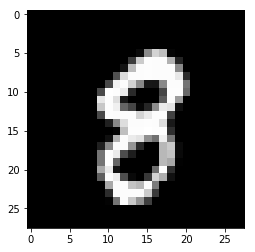

In [4]:
"""
first, we load the dataset. We are trying to do it first with MNIST
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using MNIST dataset!')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, class_nmr)
y_test = tf.keras.utils.to_categorical(y_test, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[1026, :, :, 0], cmap='gist_gray')

In [5]:
class BCNN:
    def __init__(self):
        self._build_model()
        
    def _build_model(self):
        
        """
        we build the model and get the predict, loss and optimization nodes as atributes of the class object
        we also put placeholders for the features and labels
        """
        
        self.model_in = tf.placeholder(shape=[None,28,28,1], dtype="float32")
        self.labels = tf.placeholder(shape=[None,10], dtype="float32")
        
        """
        here we model the neural network, creating separate objects for the Probability layers
        """
        self.conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
        self.x = self.conv_1(self.model_in)
        self.x = tf.keras.layers.BatchNormalization()(self.x)
        self.x = tf.keras.layers.Activation('relu')(self.x)
        self.conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
        self.x = self.conv_2(self.x)
        self.x = tf.keras.layers.BatchNormalization()(self.x)
        self.x = tf.keras.layers.Activation('relu')(self.x)
        self.x = tf.keras.layers.Flatten()(self.x)
        self.dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
        self.x = self.dense_1(self.x)
        self.dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
        self.preds = self.dense_2(self.x)  # logits
        
        """
        the elbo loss function sumbs de kl divergence loss and the softmax crossentropy
        our 'key'-node here is self.loss
        """
        self.loss_en = tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.preds)
        self.loss_kl = tf.keras.losses.KLD(self.labels, self.preds) 
        self.loss = tf.reduce_mean(tf.add(self.loss_en, self.loss_kl))
        
        """
        our train operation is also a graph node
        """
        self.optimizer = tf.train.AdamOptimizer(0.01)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def predict(self, sess, X):
        """
        prediciton with outdated sess.run and feed dict
        """
        return sess.run(self.preds, { self.model_in: X })
    
    def update(self, sess, x, y):
        """
        update with outdated sess.run and feed dict, also using the labels placeholder
        """
        feed_dict = { self.model_in: x, self.labels: y }
        _, loss = sess.run(
            [self.train_op, self.loss],
            feed_dict)
        return loss
    
    

In [6]:
def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(y_train, axis=1))

In [7]:
bcnn = BCNN()

W0913 09:42:42.420956 140542604672768 deprecation.py:323] From <ipython-input-5-5c9c0b61c4e3>:36: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

W0913 09:42:42.490380 140542604672768 deprecation.py:323] From /home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
times = []
with tf.Session() as sess:   
    tic = time.time()
    sess.run(tf.global_variables_initializer())
    tac = time.time()
    init_time = tac-tic
    print("The time for variable initalizing is : {:7.3f}".format(init_time))
    for i in range(30):
        tic = time.time()
        loss = bcnn.update(x=X_train, sess=sess, y=y_train)
        #print(loss)
        preds = bcnn.predict(sess, X_train)
        acc = accuracy(preds, y_train)
        tac = time.time()
        train_time = tac-tic
        times.append(train_time)
        print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, time: {:7.3f}".format(i, loss, acc, train_time))

The time for variable initalizing is :   0.192
Epoch: 0: loss =  11.571 , accuracy =   0.155, time:  14.974
Epoch: 1: loss =   7.987 , accuracy =   0.143, time:  10.589
Epoch: 2: loss =  11.535 , accuracy =   0.175, time:  10.479
Epoch: 3: loss =   7.399 , accuracy =   0.252, time:  10.153
Epoch: 4: loss =   4.660 , accuracy =   0.262, time:  11.198
Epoch: 5: loss =   3.006 , accuracy =   0.323, time:  11.676
Epoch: 6: loss =   2.124 , accuracy =   0.442, time:  10.899
Epoch: 7: loss =   1.813 , accuracy =   0.563, time:  11.088
Epoch: 8: loss =   1.524 , accuracy =   0.627, time:   9.968
Epoch: 9: loss =   1.194 , accuracy =   0.715, time:  10.071
Epoch: 10: loss =   0.920 , accuracy =   0.708, time:  10.310
Epoch: 11: loss =   0.847 , accuracy =   0.768, time:  10.722
Epoch: 12: loss =   0.734 , accuracy =   0.786, time:  10.571
Epoch: 13: loss =   0.718 , accuracy =   0.814, time:  10.693
Epoch: 14: loss =   0.640 , accuracy =   0.830, time:  10.933
Epoch: 15: loss =   0.577 , accur

In [15]:
### about the performance
mean = np.mean(times)
std = np.std(times)
print("In intel optimized Tensorflow 1.14, our train time mean was : {:7.3f}, with std : {:7.3f}".format(mean, std))

In intel optimized Tensorflow 1.14, our train time mean was :  10.594, with std :   0.903


In [16]:
n_mc_run = 50
med_prob_thres = 0.20

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred_logits_list = [bcnn.predict(X=X_test, sess=sess) for _ in range(n_mc_run)]  # a list of predicted logits
                                       
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9995
Unrecognizable samples: [2211 3887 6982 7302 7767]
Test accuracy on MNIST (recognizable samples): 0.08934467233616808
Test accuracy on MNIST (unrecognizable samples): 0.0


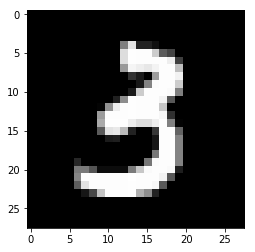

In [23]:
plt.imshow(X_test[6982, :, :, 0], cmap='gist_gray')